In [1]:
# importing packages. See https://github.com/BasisResearch/collab-creatures for repo setup
import logging
import os
import time

import numpy as np
import pandas as pd
import plotly.express as px
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean
from collab.foraging import central_park_birds as cpb
from collab.foraging.central_park_birds.central_park import cp_generate_proximity_score, cp_add_how_far_squared_scaled

import seaborn as sns

import copy

from collab.utils import find_repo_root

from functools import reduce

root = find_repo_root()
from collab.foraging import toolkit as ft

logging.basicConfig(format="%(message)s", level=logging.INFO)

# users can ignore smoke_test -- it's for automatic testing on GitHub, to make sure the notebook runs on future updates to the repository
smoke_test = "CI" in os.environ
num_frames = 5 if smoke_test else 50
num_svi_iters = 10 if smoke_test else 1000
num_samples = 10 if smoke_test else 1000

import matplotlib.pyplot as plt

notebook_starts = time.time()

Some issues to fix:
- frames input in ft.utils.object_from_data doesn't actually change anything. Either remove input, or make it actually change the frame range.
- ft.animate_foragers plot overflows, check if it returns figure, and if fig can be resized
- ft.animate_foragers assumes no timebins are skipped
- sometimes get comfusing bugs when running on too little data (e.g. just 100 frames)

In [2]:
# load the data
path = os.path.join(root, "data/foraging/gerbils/2020_08_01_18_10_16_589437_compressed_Day_spine (1).npy")
data = np.load(path)

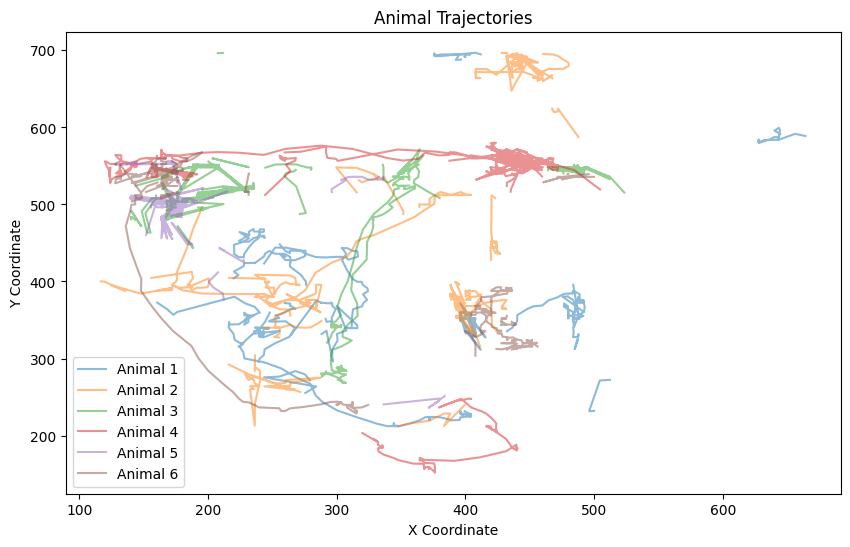

In [3]:
# plot the data
# the dimensions of the data are (time, animal_num, XY)

#  data shape is (time, animal_num, XY)

time_steps, animal_num, _ = data.shape

# Create a plot for each animal's trajectory
plt.figure(figsize=(10, 6))

tmin = 500
tmax = 2000

for i in range(animal_num):
    # Extract the X and Y coordinates for the current animal
    x_coords = data[tmin:tmax, i, 0]
    y_coords = data[tmin:tmax, i, 1]

    # Plot the trajectory
    plt.plot(x_coords, y_coords, label=f"Animal {i+1}", alpha = .5)

# Add labels and a legend
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Animal Trajectories")
plt.legend()

# Show the plot
plt.show()

In [4]:
# Format the data in dataframes as expected for further analysis

# make a dataframe with columns for x, y, time, forager (animal_num), and type (always gerbil)
# Initialize lists to hold the data for the dataframe
time_list = []
forager_list = []
x_list = []
y_list = []
type_list = []

# Populate the lists with the data
for timei in range(time_steps):
    for forager in range(animal_num):
        x_list.append(data[timei, forager, 0])
        y_list.append(data[timei, forager, 1])
        time_list.append(timei)
        forager_list.append(forager)
        type_list.append("gerbil")

# Create the dataframe
gerbil_df = pd.DataFrame(
    {
        "time": time_list,
        "forager": forager_list,
        "x": x_list,
        "y": y_list,
        "type": type_list,
    }
)


# Define the range and location for rewards
x_range = range(250, 651)  # x locations from 250 to 650
y_location = 700  # y location fixed at 700

# Use numpy to efficiently create arrays for the rewards DataFrame
x_array = np.tile(np.arange(250, 651), time_steps)
y_array = np.full(x_array.shape, y_location)
time_array = np.repeat(np.arange(time_steps), len(x_range))

# Create the rewards DataFrame
rewardsDF = pd.DataFrame({"x": x_array, "y": y_array, "time": time_array})

# Remove times where any value in gerbil_df is NaN
nan_times = gerbil_df[gerbil_df.isna().any(axis=1)]["time"]

# Filter gerbil_df to exclude rows with these times
gerbil_df_clean = gerbil_df[~gerbil_df["time"].isin(nan_times)]

# Filter rewardsDF to exclude rows with these times
rewardsDF_clean = rewardsDF[~rewardsDF["time"].isin(nan_times)]

# Display the cleaned DataFrames
print(gerbil_df_clean.head())
print(gerbil_df_clean['time'].unique().shape)
print(rewardsDF_clean.head())

# restrict to time range
gerbil_df_clean = gerbil_df_clean[
    (gerbil_df_clean["time"] >= tmin) & (gerbil_df_clean["time"] <= tmax)
]
rewardsDF_clean = rewardsDF_clean[
    (rewardsDF_clean["time"] >= tmin) & (rewardsDF_clean["time"] <= tmax)
]

forager_object = ft.utils.object_from_data(
    gerbil_df_clean,
    grid_size=1000,
    rewardsDF=rewardsDF_clean,
    frames=None,
    calculate_step_size_max=True,
)

      time  forager           x           y    type
2922   487        0  788.811279  583.877930  gerbil
2923   487        1  395.837769  379.639740  gerbil
2924   487        2  199.334747  504.811859  gerbil
2925   487        3  388.397308  243.945663  gerbil
2926   487        4  180.298141  495.453278  gerbil
(7946,)
          x    y  time
195287  250  700   487
195288  251  700   487
195289  252  700   487
195290  253  700   487
195291  254  700   487


In [5]:
ft.animate_foragers(
    forager_object, plot_rewards=True, width=1000, height=710, point_size=6
)

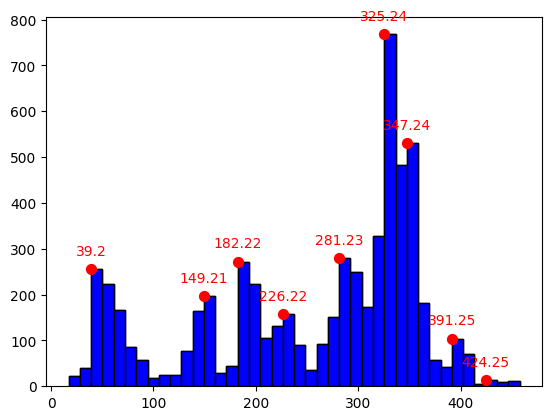

In [6]:
forager_distances = ft.foragers_to_forager_distances(forager_object)
ft.distances_and_peaks(forager_distances)

# this seems multimodal, let's generate different proximity predictors centered approximately around the peaks
# 40, 150, 180, 280, 330

In [7]:
forager_vis = cpb.cp_generate_visibility(forager_object.foragers, 
                                         grid_size = forager_object.grid_size,
                                        visibility_range = 500, sampling_rate=0.001)
forager_object.visibility = forager_vis["visibility"]
forager_object.visibilityDF = forager_vis["visibilityDF"]
display(forager_object.visibilityDF.head())
display(forager_object.visibilityDF.shape)

x    y   distance  distance_x  distance_y  visibility  forager  time
987231  988  232  15.055602  576.073303  462.737732    0.998882        1   785
500891  501  892  23.930548   89.073303  197.262268    0.997175        1   785
733378  734  379   3.559655  322.073303  315.737732    0.999937        1   785
731479  732  480  14.514515  320.073303  214.737732    0.998961        1   785
399758  400  759  10.230892   11.926697   64.262268    0.999484        1   785

(752039, 8)

In [8]:
optimal_candidates = [40, 150, 180, 280, 330]
proximity_dict = {}
for candidate in optimal_candidates:
    proximity_dict[str(candidate)] = cp_generate_proximity_score(forager_object, visibility_range = 500,
                                                   getting_worse = candidate/2,
                                                   optimal = candidate,
                                                   proximity_decay = 0.1,
                                                   forager_distances = forager_distances)

#just to be used by how far, doesnt matter which one we grab here  
forager_object.proximity = proximity_dict["40"]["proximity"]
forager_object.proximityDF = proximity_dict["40"]["proximityDF"]


/home/rafal/s78projects/collaborative-intelligence/collab/foraging/central_park_birds/central_park.py:140: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/home/rafal/s78projects/collaborative-intelligence/collab/foraging/central_park_birds/central_park.py:140: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [9]:
optimal_candidates =  ["40", "150", "180", "280", "330"]

proximity_frames = []

for candidate in optimal_candidates:

    proximity_dict[candidate]['proximityDF'].rename(columns={
        "proximity": f'proximity_{candidate}',
        "proximity_standardized": f'proximity_standardized_{candidate}'
    }, inplace=True)

    display(proximity_dict[candidate]['proximityDF'].head())
    proximity_frames.append(proximity_dict[candidate]['proximityDF'])

result_df = proximity_frames[0]

for i in range(1, len(proximity_frames)):
    proximity_predictors = proximity_frames[i].iloc[:, -2:]
    result_df = pd.concat([result_df, proximity_predictors], axis=1)

display(result_df.head())


x    y   distance  distance_x  distance_y  visibility  forager  \
987231  988  232  15.055602  576.073303  462.737732    0.998882        1   
500891  501  892  23.930548   89.073303  197.262268    0.997175        1   
733378  734  379   3.559655  322.073303  315.737732    0.999937        1   
731479  732  480  14.514515  320.073303  214.737732    0.998961        1   
399758  400  759  10.230892   11.926697   64.262268    0.999484        1   

        time  proximity_40  proximity_standardized_40  
987231   785  3.089543e-37                  -0.106364  
500891   785  1.280025e-19                  -0.106364  
733378   785  1.010666e-24                  -0.106364  
731479   785  1.002019e-23                  -0.106364  
399758   785  1.809231e-12                   0.286558

x    y   distance  distance_x  distance_y  visibility  forager  \
987231  988  232  15.055602  576.073303  462.737732    0.998882        1   
500891  501  892  23.930548   89.073303  197.262268    0.997175        1   
733378  734  379   3.559655  322.073303  315.737732    0.999937        1   
731479  732  480  14.514515  320.073303  214.737732    0.998961        1   
399758  400  759  10.230892   11.926697   64.262268    0.999484        1   

        time  proximity_150  proximity_standardized_150  
987231   785   2.893632e-31                   -0.106364  
500891   785   1.198857e-13                   -0.106364  
733378   785   9.465785e-19                   -0.106364  
731479   785   9.384800e-18                   -0.106364  
399758   785   1.694506e-06                    0.286558

x    y   distance  distance_x  distance_y  visibility  forager  \
987231  988  232  15.055602  576.073303  462.737732    0.998882        1   
500891  501  892  23.930548   89.073303  197.262268    0.997175        1   
733378  734  379   3.559655  322.073303  315.737732    0.999937        1   
731479  732  480  14.514515  320.073303  214.737732    0.998961        1   
399758  400  759  10.230892   11.926697   64.262268    0.999484        1   

        time  proximity_180  proximity_standardized_180  
987231   785   1.230404e-29                   -0.106364  
500891   785   5.097671e-12                   -0.106364  
733378   785   4.024954e-17                   -0.106364  
731479   785   3.990518e-16                   -0.106364  
399758   785   7.205225e-05                    0.286558

x    y   distance  distance_x  distance_y  visibility  forager  \
987231  988  232  15.055602  576.073303  462.737732    0.998882        1   
500891  501  892  23.930548   89.073303  197.262268    0.997175        1   
733378  734  379   3.559655  322.073303  315.737732    0.999937        1   
731479  732  480  14.514515  320.073303  214.737732    0.998961        1   
399758  400  759  10.230892   11.926697   64.262268    0.999484        1   

        time  proximity_280  proximity_standardized_280  
987231   785   3.301632e-24                   -0.283715  
500891   785   1.367895e-06                   -0.283708  
733378   785   1.080045e-11                   -0.283715  
731479   785   1.070805e-10                   -0.283715  
399758   785   9.154424e-01                    4.083625

x    y   distance  distance_x  distance_y  visibility  forager  \
987231  988  232  15.055602  576.073303  462.737732    0.998882        1   
500891  501  892  23.930548   89.073303  197.262268    0.997175        1   
733378  734  379   3.559655  322.073303  315.737732    0.999937        1   
731479  732  480  14.514515  320.073303  214.737732    0.998961        1   
399758  400  759  10.230892   11.926697   64.262268    0.999484        1   

        time  proximity_330  proximity_standardized_330  
987231   785   1.710288e-21                   -0.404004  
500891   785   7.085872e-04                   -0.401665  
733378   785   5.594773e-09                   -0.404004  
731479   785   5.546907e-08                   -0.404003  
399758   785   9.922519e-01                    2.871162

x    y   distance  distance_x  distance_y  visibility  forager  \
987231  988  232  15.055602  576.073303  462.737732    0.998882        1   
500891  501  892  23.930548   89.073303  197.262268    0.997175        1   
733378  734  379   3.559655  322.073303  315.737732    0.999937        1   
731479  732  480  14.514515  320.073303  214.737732    0.998961        1   
399758  400  759  10.230892   11.926697   64.262268    0.999484        1   

        time  proximity_40  proximity_standardized_40  proximity_150  \
987231   785  3.089543e-37                  -0.106364   2.893632e-31   
500891   785  1.280025e-19                  -0.106364   1.198857e-13   
733378   785  1.010666e-24                  -0.106364   9.465785e-19   
731479   785  1.002019e-23                  -0.106364   9.384800e-18   
399758   785  1.809231e-12                   0.286558   1.694506e-06   

        proximity_standardized_150  proximity_180  proximity_standardized_180  \
987231                   -0.106364   1.230404e-29                   -0.106364   
500891                   -0.106364   5.097671e-12                   -0.106364   
733378                   -0.106364   4.024954e-17                   -0.106364   
731479                   -0.106364   3.990518e-16                   -0.106364   
399758                    0.286558   7.205225e-05                    0.286558   

        proximity_280  proximity_standardized_280  proximity_330  \
987231   3.301632e-24                   -0.283715   1.710288e-21   
500891   1.367895e-06                   -0.283708   7.085872e-04   
733378   1.080045e-11                   -0.283715   5.594773e-09   
731479   1.070805e-10                   -0.283715   5.546907e-08   
399758   9.154424e-01                    4.083625   9.922519e-01   

        proximity_standardized_330  
987231                   -0.404004  
500891                   -0.401665  
733378                   -0.404004  
731479                   -0.404003  
399758                    2.871162

In [10]:
if "distance_x" in result_df.columns and "distance_y" in result_df.columns:
    result_df.drop(columns = ["distance_x", "distance_y"], inplace=True)


In [11]:
cp_add_how_far_squared_scaled(forager_object)

forager_object.how_farDF.head()

result_df = pd.concat([result_df, forager_object.how_farDF.iloc[:, -3:]], axis=1)
display(result_df.head())

x    y   distance  visibility  forager  time  proximity_40  \
987231  988  232  15.055602    0.998882        1   785  3.089543e-37   
500891  501  892  23.930548    0.997175        1   785  1.280025e-19   
733378  734  379   3.559655    0.999937        1   785  1.010666e-24   
731479  732  480  14.514515    0.998961        1   785  1.002019e-23   
399758  400  759  10.230892    0.999484        1   785  1.809231e-12   

        proximity_standardized_40  proximity_150  proximity_standardized_150  \
987231                  -0.106364   2.893632e-31                   -0.106364   
500891                  -0.106364   1.198857e-13                   -0.106364   
733378                  -0.106364   9.465785e-19                   -0.106364   
731479                  -0.106364   9.384800e-18                   -0.106364   
399758                   0.286558   1.694506e-06                    0.286558   

        proximity_180  proximity_standardized_180  proximity_280  \
987231   1.230404e-29                   -0.106364   3.301632e-24   
500891   5.097671e-12                   -0.106364   1.367895e-06   
733378   4.024954e-17                   -0.106364   1.080045e-11   
731479   3.990518e-16                   -0.106364   1.070805e-10   
399758   7.205225e-05                    0.286558   9.154424e-01   

        proximity_standardized_280  proximity_330  proximity_standardized_330  \
987231                   -0.283715   1.710288e-21                   -0.404004   
500891                   -0.283708   7.085872e-04                   -0.401665   
733378                   -0.283715   5.594773e-09                   -0.404004   
731479                   -0.283715   5.546907e-08                   -0.404003   
399758                    4.083625   9.922519e-01                    2.871162   

        how_far_squared     how_far  how_far_squared_scaled  
987231         552857.0  743.543543               -0.353030  
500891          47252.0  217.375252                0.884358  
733378         207418.0  455.431663                0.492377  
731479         152281.0  390.231982                0.627316  
399758           4018.0   63.387696                0.990167

In [12]:
if "forager" in result_df.columns:
    result_df['forager_id'] = pd.factorize(result_df['forager'])[0]
    result_df.drop(columns = ["forager"], inplace=True)

if "time" in result_df.columns:
    result_df['time_id'] = pd.factorize(result_df['time'])[0]
    result_df.drop(columns = ["time"], inplace=True)


display(result_df.head())

# see if any nans
display(result_df.isna().sum()/len(result_df))

result_df = result_df.dropna()

display(result_df.isna().sum()/len(result_df))


x    y   distance  visibility  proximity_40  \
987231  988  232  15.055602    0.998882  3.089543e-37   
500891  501  892  23.930548    0.997175  1.280025e-19   
733378  734  379   3.559655    0.999937  1.010666e-24   
731479  732  480  14.514515    0.998961  1.002019e-23   
399758  400  759  10.230892    0.999484  1.809231e-12   

        proximity_standardized_40  proximity_150  proximity_standardized_150  \
987231                  -0.106364   2.893632e-31                   -0.106364   
500891                  -0.106364   1.198857e-13                   -0.106364   
733378                  -0.106364   9.465785e-19                   -0.106364   
731479                  -0.106364   9.384800e-18                   -0.106364   
399758                   0.286558   1.694506e-06                    0.286558   

        proximity_180  proximity_standardized_180  proximity_280  \
987231   1.230404e-29                   -0.106364   3.301632e-24   
500891   5.097671e-12                   -0.106364   1.367895e-06   
733378   4.024954e-17                   -0.106364   1.080045e-11   
731479   3.990518e-16                   -0.106364   1.070805e-10   
399758   7.205225e-05                    0.286558   9.154424e-01   

        proximity_standardized_280  proximity_330  proximity_standardized_330  \
987231                   -0.283715   1.710288e-21                   -0.404004   
500891                   -0.283708   7.085872e-04                   -0.401665   
733378                   -0.283715   5.594773e-09                   -0.404004   
731479                   -0.283715   5.546907e-08                   -0.404003   
399758                    4.083625   9.922519e-01                    2.871162   

        how_far_squared     how_far  how_far_squared_scaled  forager_id  \
987231         552857.0  743.543543               -0.353030           0   
500891          47252.0  217.375252                0.884358           0   
733378         207418.0  455.431663                0.492377           0   
731479         152281.0  390.231982                0.627316           0   
399758           4018.0   63.387696                0.990167           0   

        time_id  
987231        0  
500891        0  
733378        0  
731479        0  
399758        0

x                             0.000000
y                             0.000000
distance                      0.000000
visibility                    0.000000
proximity_40                  0.000000
proximity_standardized_40     0.000000
proximity_150                 0.000000
proximity_standardized_150    0.000000
proximity_180                 0.000000
proximity_standardized_180    0.000000
proximity_280                 0.000000
proximity_standardized_280    0.000000
proximity_330                 0.000000
proximity_standardized_330    0.000000
how_far_squared               0.004956
how_far                       0.004956
how_far_squared_scaled        0.004956
forager_id                    0.000000
time_id                       0.000000
dtype: float64

x                             0.0
y                             0.0
distance                      0.0
visibility                    0.0
proximity_40                  0.0
proximity_standardized_40     0.0
proximity_150                 0.0
proximity_standardized_150    0.0
proximity_180                 0.0
proximity_standardized_180    0.0
proximity_280                 0.0
proximity_standardized_280    0.0
proximity_330                 0.0
proximity_standardized_330    0.0
how_far_squared               0.0
how_far                       0.0
how_far_squared_scaled        0.0
forager_id                    0.0
time_id                       0.0
dtype: float64

In [13]:
#TODO inspect spearman correlation between different predictor scores

In [14]:

predictors = {key: torch.tensor(result_df[key].values) for key in result_df.columns}

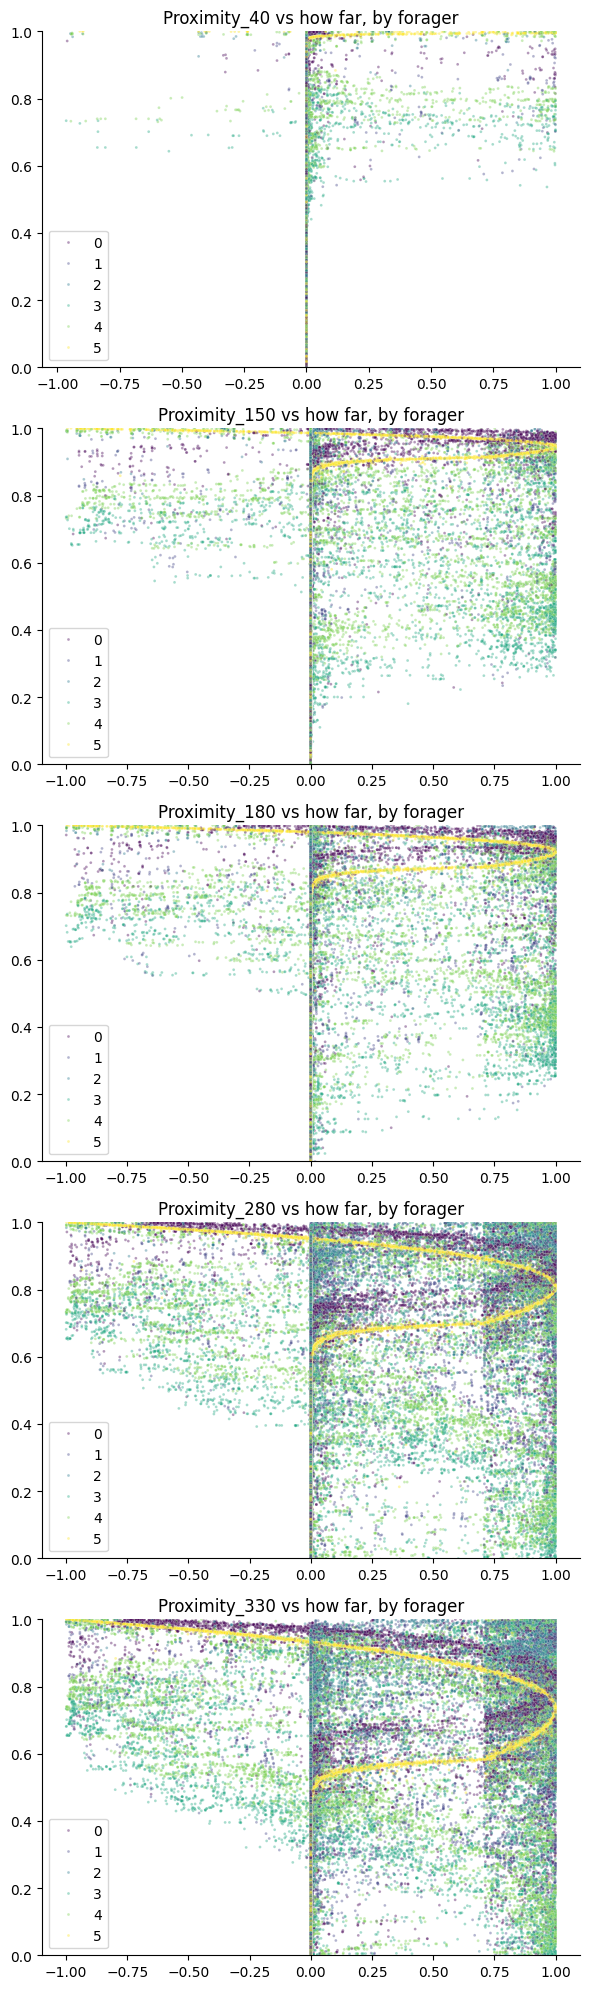

In [15]:
# further subsample for plotting and plot
sampling_rate = 0.2

fig, axes = plt.subplots(len(optimal_candidates), 1, figsize=(6, len(optimal_candidates) * 4))

if len(optimal_candidates) == 1:
    axes = [axes]

for i, (proximity, ax) in enumerate(zip(optimal_candidates, axes)):
    
    total_samples = predictors[f'proximity_{proximity}'].size(0)
    sample_indices = torch.randperm(total_samples)[:int(sampling_rate * total_samples)]
    
    x_data = predictors[f'proximity_{proximity}'][sample_indices].cpu().numpy()
    y_data = predictors['how_far_squared_scaled'][sample_indices].cpu().numpy()
    hue_data = predictors['forager_id'][sample_indices].cpu().numpy()
    
    sns.scatterplot(x=x_data, 
                    y=y_data, 
                    hue=hue_data, 
                    palette='viridis', 
                    s=4, alpha=0.4, ax=ax)
    
    ax.set_ylim(0, 1)
    ax.set_title(f"Proximity_{proximity} vs how far, by forager")
    sns.despine()
    plt.tight_layout()
    ax


In [16]:
predictors.keys()

dict_keys(['x', 'y', 'distance', 'visibility', 'proximity_40', 'proximity_standardized_40', 'proximity_150', 'proximity_standardized_150', 'proximity_180', 'proximity_standardized_180', 'proximity_280', 'proximity_standardized_280', 'proximity_330', 'proximity_standardized_330', 'how_far_squared', 'how_far', 'how_far_squared_scaled', 'forager_id', 'time_id'])

/home/rafal/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning:

Can't initialize NVML



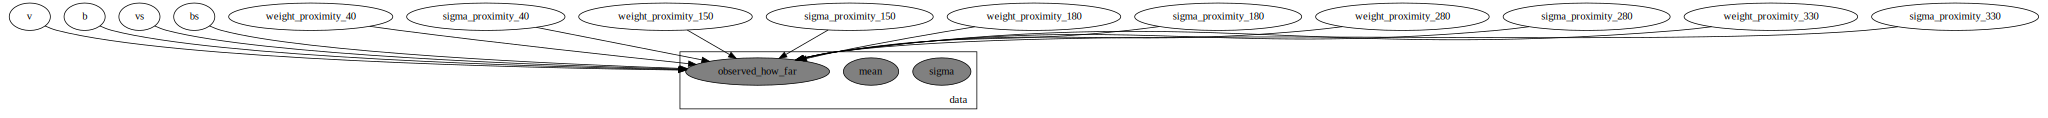

In [17]:
class  GerbilModel(pyro.nn.PyroModule):
    def __init__(
        self,
        predictors: dict,
        leeway=0.9,
    ):
        super().__init__()

        self.predictors = predictors
        self.leeway = leeway
        self.n = len(predictors["forager_id"])

        
    def forward(
        self,
        data = predictors,
        proximities = [40, 150, 180, 280, 330],
        leeway=0.4,
    ):
        visibility = data["visibility"]
        how_far = data["how_far_squared_scaled"]

        proximity_names = [f'proximity_{proximity}' for proximity in proximities]
        proximity_tensors = {name: self.predictors[name] for name in proximity_names}
        
        v = pyro.sample("v", dist.Normal(0.,leeway))
        b = pyro.sample("b", dist.Normal(0.5,.3))

        vs = pyro.sample("vs", dist.Exponential(10.))
        bs = pyro.sample("bs", dist.Exponential(10.))

        weights = {}
        sigmas = {}
        for key in proximity_tensors:
            weights[key] = pyro.sample(f"weight_{key}",
                        dist.Normal(0., leeway))
            
            sigmas[key] = pyro.sample(f"sigma_{key}",
                        dist.Exponential(9.))
        


        with pyro.plate("data", self.n):
            sigma = pyro.deterministic(
                "sigma", 
                sum([torch.abs(proximity_tensors[key]) * sigmas[key] 
                                        for key in proximity_tensors]) +
                                        vs * torch.abs(visibility) + bs)

            assert torch.all(sigma > 0), "Sigma is not positive"
            
           
            mean = pyro.deterministic(
                "mean",
                sum([proximity_tensors[key] * weights[key] for key 
                     in proximity_tensors]) + v * visibility + b
            )

            pyro.sample("observed_how_far", 
                            dist.Normal(mean, sigma), obs=how_far)
        

gerbil_model = GerbilModel(predictors)

with pyro.poutine.trace() as tr:
        gerbil_model(predictors)

pyro.render_model(
    lambda: gerbil_model(predictors),
)

In [52]:
# helper function for inference

def get_samples(
    model=gerbil_model,
    data = predictors,
    num_svi_iters=num_svi_iters,
    num_samples=num_samples,
):
    guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
    svi = SVI(model, guide, optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

    iterations = []
    losses = []

    logging.info(f"Starting SVI inference with {num_svi_iters} iterations.")
    start_time = time.time()
    pyro.clear_param_store()
    for i in range(num_svi_iters):
        elbo = svi.step(data)
        iterations.append(i)
        losses.append(elbo)
        if i % 200 == 0:
            logging.info("Step {}, elbo loss: {}".format(i, elbo))
    end_time = time.time()
    elapsed_time = end_time - start_time
    logging.info("SVI inference completed in %.2f seconds.", elapsed_time)

    if not smoke_test:
        fig = px.line(
            x=iterations, y=losses, title="ELBO loss", template="presentation"
        )
        labels = {"iterations": "iteration", "losses": "loss"}
        fig.update_xaxes(showgrid=False, title_text=labels["iterations"])
        fig.update_yaxes(showgrid=False, title_text=labels["losses"])
        fig.update_layout(width=700)
        fig.show()

    predictive = Predictive(
        model, guide=guide, num_samples=num_samples, parallel=True
    )
    svi_samples = {
        k: v.flatten().reshape(num_samples, -1).detach().cpu().numpy()
        for k, v in predictive().items()
    }

    return {"svi_samples": svi_samples, "svi_guide": guide, "svi_predictive": predictive}

In [19]:
samples= get_samples(num_svi_iters=600)

2024-08-08 10:47:43,823 - Starting SVI inference with 600 iterations.


2024-08-08 10:47:44,844 - Step 0, elbo loss: 4214502.912682263
2024-08-08 10:47:57,141 - Step 200, elbo loss: 489398.8789203735
2024-08-08 10:48:09,337 - Step 400, elbo loss: 485784.32521748083
2024-08-08 10:48:19,042 - SVI inference completed in 35.22 seconds.


In [73]:
def summary(samples, vars_of_interest = None):
    if vars_of_interest is None:
        vars_of_interest = [
        'v', 'weight_proximity_40', 'weight_proximity_150', 'weight_proximity_180', 
        'weight_proximity_280', 'weight_proximity_330',
        ]

    percentiles = [0.05, 0.25, 0.5, 0.75, 0.95]

    for key in vars_of_interest:
        mean = samples['svi_samples'][key].mean(axis = 0)
        std = samples['svi_samples'][key].std(axis = 0)
        print(f"{key}: {mean} +/- {std}")

summary(samples)


v: [-0.14498258] +/- [0.0606269]
weight_proximity_40: [2.3972006] +/- [0.126122]
weight_proximity_150: [0.6701708] +/- [0.06610024]
weight_proximity_180: [0.05370423] +/- [0.05074086]
weight_proximity_280: [0.12287875] +/- [0.04920954]
weight_proximity_330: [0.37848607] +/- [0.05665569]


In [22]:
predictors_for_eval = copy.deepcopy(predictors)
predictors_for_eval['how_far_squared_scaled'] = None

def calculate_R_squared(model,guide):
    predictive = pyro.infer.Predictive(model, guide=guide, num_samples=100, parallel = True)
    predictions = predictive(predictors_for_eval)

    mean_preds = predictions['observed_how_far'].mean(axis=0)


    assert not torch.equal(mean_preds, 
                       predictors['how_far_squared_scaled']), \
    "Predictions should not be the same as the observed values"

    observed_mean = torch.mean(predictors['how_far_squared_scaled'])

    tss = torch.sum((predictors['how_far_squared_scaled'] - observed_mean) ** 2)
    rss = torch.sum((predictors['how_far_squared_scaled'] - mean_preds) ** 2)

    r_squared = 1 - (rss / tss)

    return r_squared.float().item()

calculate_R_squared(gerbil_model,samples['svi_guide'])

0.14339208602905273

In [71]:
import pyro
import pyro.distributions as dist
import torch
import pyro.nn
from pyro.nn import PyroModule

class GerbilModelNoPooling(pyro.nn.PyroModule):
    def __init__(
        self,
        predictors: dict,
        leeway=0.9,
    ):
        super().__init__()

        self.predictors = predictors
        self.leeway = leeway
        self.n = len(predictors["forager_id"])
        
    
    def forward(
        self,
        data=None,
        proximities=[40, 150, 180, 280, 330],
        leeway=0.4,
    ):
        if data is None:
            data = self.predictors
        
        visibility = data["visibility"]
        how_far = data["how_far_squared_scaled"]
        forager_ids = data["forager_id"]
        n_foragers = len(forager_ids.unique())
        
        proximity_names = [f'proximity_{proximity}' for proximity in proximities]
        proximity_tensors = {name: self.predictors[name] for name in proximity_names}
        
        v = pyro.sample("v", dist.Normal(0., leeway))
        b = pyro.sample("b", dist.Normal(0.5, 0.3))
        
        vs = pyro.sample("vs", dist.Exponential(10.))
        bs = pyro.sample("bs", dist.Exponential(10.))

        with pyro.plate("foragers", n_foragers, dim = -2):
            weights = {}
            sigmas = {}
            for key in proximity_tensors:
                weights[key] = pyro.sample(f"weight_{key}",
                            dist.Normal(0., leeway))
                
                sigmas[key] = pyro.sample(f"sigma_{key}",
                            dist.Exponential(9.))

        sigma = pyro.deterministic(
                "sigma",
                torch.einsum("...fd, ... d -> d", sigmas[key][forager_ids], 
                             torch.abs(proximity_tensors[key]))
                               + vs * torch.abs(visibility) + bs
        )

        mean = pyro.deterministic(
            "mean",
            torch.einsum("...fd, ... d -> d", weights[key][forager_ids], 
                         proximity_tensors[key]) + v * visibility + b
        )   
         
    
        with pyro.plate("data", self.n):
            

            pyro.sample("observed_how_far", 
                        dist.Normal(mean, sigma), obs=how_far)
                
                  
gerbil_model_no_pooling = GerbilModelNoPooling(predictors)

with  pyro.poutine.trace() as tr:
    gerbil_model_no_pooling(predictors)

In [75]:
samples_no_pooling = get_samples(gerbil_model_no_pooling, num_svi_iters=1400)  #note slower convergence

2024-08-08 11:42:10,377 - Starting SVI inference with 1400 iterations.
2024-08-08 11:42:10,699 - Step 0, elbo loss: 5664416.119373371
2024-08-08 11:42:47,764 - Step 200, elbo loss: 3541558.1033259192
2024-08-08 11:43:22,736 - Step 400, elbo loss: 3361828.8885743283
2024-08-08 11:43:58,965 - Step 600, elbo loss: 3608561.805239345
2024-08-08 11:44:36,292 - Step 800, elbo loss: 2914299.113643365
2024-08-08 11:45:14,241 - Step 1000, elbo loss: 3459289.443945377
2024-08-08 11:45:52,192 - Step 1200, elbo loss: 2808889.673219363
2024-08-08 11:46:29,984 - SVI inference completed in 259.61 seconds.


In [76]:
summary(samples_no_pooling)

v: [-0.17744961] +/- [0.04376784]
weight_proximity_40: [-0.02571342 -0.12075571 -0.08733933 -0.03507446 -0.00034687 -0.07278573] +/- [0.401433   0.42136556 0.3930046  0.3984423  0.4027879  0.37157404]
weight_proximity_150: [ 0.08021192  0.00780221  0.04022782 -0.00710334  0.0642556  -0.01222653] +/- [0.3601994  0.35816944 0.37532055 0.38522065 0.37257317 0.39579874]
weight_proximity_180: [-0.03413036  0.05605515 -0.01247891  0.09651847 -0.10777805  0.02985012] +/- [0.4101392  0.40653333 0.4003707  0.3904688  0.4155525  0.39729238]
weight_proximity_280: [ 0.01750897 -0.00213268 -0.04559438  0.01864097  0.04064604 -0.03006994] +/- [0.38162673 0.44846797 0.4068978  0.39040637 0.3715259  0.43863237]
weight_proximity_330: [-0.00144808 -0.00140251 -0.00150911 -0.00173504 -0.00156601 -0.00166607] +/- [0.00359129 0.00395737 0.0039144  0.00403459 0.0033403  0.00432413]


In [79]:
class GerbilModelPartialPooling(pyro.nn.PyroModule):
    def __init__(
        self,
        predictors: dict,
        leeway=0.9,
    ):
        super().__init__()

        self.predictors = predictors
        self.leeway = leeway
        self.n = len(predictors["forager_id"])

    def forward(
        self,
        data=None,
        proximities=[40, 150, 180, 280, 330],
        leeway=0.4,
    ):
        if data is None:
            data = self.predictors
        
        visibility = data["visibility"]
        how_far = data["how_far_squared_scaled"]
        forager_ids = data["forager_id"]
        n_foragers = len(forager_ids.unique())
        
        proximity_names = [f'proximity_{proximity}' for proximity in proximities]
        proximity_tensors = {name: self.predictors[name] for name in proximity_names}
        
        v = pyro.sample("v", dist.Normal(0., leeway))
        b = pyro.sample("b", dist.Normal(0.5, 0.3))
        vs = pyro.sample("vs", dist.Exponential(10.))
        bs = pyro.sample("bs", dist.Exponential(10.))
        
        # Sample global distributions for weights and sigmas
        weights_global = {}
        sigmas_global = {}
        for key in proximity_tensors:
            weights_global[key] = pyro.sample(f"weight_global_{key}",
                                              dist.Normal(0., leeway))
            sigmas_global[key] = pyro.sample(f"sigma_global_{key}",
                                              dist.Exponential(9.))

        # Sample per-forager parameters from global distributions
        with pyro.plate("foragers", len(forager_ids.unique())):
            weights = {key: pyro.sample(f"weight_{key}_{i}",
                                       dist.Normal(weights_global[key], 0.1))
                       for i in range(n_foragers)
                       for key in proximity_tensors}
            sigmas = {key: pyro.sample(f"sigma_{key}_{i}",
                                      dist.Exponential(sigmas_global[key]))
                      for i in range(n_foragers)
                      for key in proximity_tensors}

        sigma = pyro.deterministic(
                "sigma",
                torch.einsum("...fd, ... d -> d", sigmas[key][forager_ids], 
                             torch.abs(proximity_tensors[key]))
                               + vs * torch.abs(visibility) + bs
        )

        mean = pyro.deterministic(
            "mean",
            torch.einsum("...fd, ... d -> d", weights[key][forager_ids], 
                         proximity_tensors[key]) + v * visibility + b
        )   
         
    
        with pyro.plate("data", self.n):
            

            pyro.sample("observed_how_far", 
                        dist.Normal(mean, sigma), obs=how_far)

# Instantiate and use the model
gerbil_model_partial_pooling = GerbilModelPartialPooling(predictors)

with pyro.poutine.trace() as tr:
    gerbil_model_partial_pooling(predictors)


RuntimeError: einsum(): the number of subscripts in the equation (2) is more than the number of dimensions (1) for operand 0

In [78]:
samples_partial_pooling = get_samples(gerbil_model_partial_pooling, num_svi_iters=50)

2024-08-08 11:50:55,615 - Starting SVI inference with 50 iterations.
2024-08-08 11:50:56,453 - Step 0, elbo loss: 3338954.493227197
2024-08-08 11:51:32,530 - SVI inference completed in 36.91 seconds.


RuntimeError: The size of tensor a (748312) must match the size of tensor b (6) at non-singleton dimension 1
                   Trace Shapes:         
                    Param Sites:         
                   Sample Sites:         
                          v dist 1000 1 |
                           value 1000 1 |
                          b dist 1000 1 |
                           value 1000 1 |
                         vs dist 1000 1 |
                           value 1000 1 |
                         bs dist 1000 1 |
                           value 1000 1 |
 weight_global_proximity_40 dist 1000 1 |
                           value 1000 1 |
  sigma_global_proximity_40 dist 1000 1 |
                           value 1000 1 |
weight_global_proximity_150 dist 1000 1 |
                           value 1000 1 |
 sigma_global_proximity_150 dist 1000 1 |
                           value 1000 1 |
weight_global_proximity_180 dist 1000 1 |
                           value 1000 1 |
 sigma_global_proximity_180 dist 1000 1 |
                           value 1000 1 |
weight_global_proximity_280 dist 1000 1 |
                           value 1000 1 |
 sigma_global_proximity_280 dist 1000 1 |
                           value 1000 1 |
weight_global_proximity_330 dist 1000 1 |
                           value 1000 1 |
 sigma_global_proximity_330 dist 1000 1 |
                           value 1000 1 |
                   foragers dist        |
                           value      6 |
      weight_proximity_40_0 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_150_0 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_180_0 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_280_0 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_330_0 dist 1000 6 |
                           value 1000 6 |
      weight_proximity_40_1 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_150_1 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_180_1 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_280_1 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_330_1 dist 1000 6 |
                           value 1000 6 |
      weight_proximity_40_2 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_150_2 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_180_2 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_280_2 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_330_2 dist 1000 6 |
                           value 1000 6 |
      weight_proximity_40_3 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_150_3 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_180_3 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_280_3 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_330_3 dist 1000 6 |
                           value 1000 6 |
      weight_proximity_40_4 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_150_4 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_180_4 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_280_4 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_330_4 dist 1000 6 |
                           value 1000 6 |
      weight_proximity_40_5 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_150_5 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_180_5 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_280_5 dist 1000 6 |
                           value 1000 6 |
     weight_proximity_330_5 dist 1000 6 |
                           value 1000 6 |
       sigma_proximity_40_0 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_150_0 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_180_0 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_280_0 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_330_0 dist 1000 6 |
                           value 1000 6 |
       sigma_proximity_40_1 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_150_1 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_180_1 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_280_1 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_330_1 dist 1000 6 |
                           value 1000 6 |
       sigma_proximity_40_2 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_150_2 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_180_2 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_280_2 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_330_2 dist 1000 6 |
                           value 1000 6 |
       sigma_proximity_40_3 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_150_3 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_180_3 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_280_3 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_330_3 dist 1000 6 |
                           value 1000 6 |
       sigma_proximity_40_4 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_150_4 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_180_4 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_280_4 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_330_4 dist 1000 6 |
                           value 1000 6 |
       sigma_proximity_40_5 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_150_5 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_180_5 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_280_5 dist 1000 6 |
                           value 1000 6 |
      sigma_proximity_330_5 dist 1000 6 |
                           value 1000 6 |

In [34]:
ft.plot_coefs(samples_random, "Gerbils", nbins=120, ann_start_y=160, ann_break_y=50)